In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from random import randint
import spacy, nltk, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pickle import dump, load
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalMaxPooling1D, LSTM, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model, Sequential, load_model
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
nlp = spacy.load('en_core_web_sm')
# default were only 1000000
nlp.max_length = 1200000

# 1) Embedding Layers

In [ ]:
sent=['the glass of milk',  
      'the glass of juice', 
      'the cup of tea', 
      'I am a good boy', 
      'I am a good developer', 
      'understand the meaning of words', 
      'your videos are good',]

In [ ]:
# set max vocab size to 10000
onehot_rep =  [text.one_hot(words, 10000)for words in sent] 
print(onehot_rep)

[[9456, 5698, 5344, 7743], [9456, 5698, 5344, 4644], [9456, 205, 5344, 9262], [9606, 7158, 3319, 760, 2756], [9606, 7158, 3319, 760, 6642], [9182, 9456, 2060, 5344, 8395], [7136, 3085, 9556, 760]]


In [ ]:
# add padding to ensure uniform size
sent_length = max([len(x) for x in onehot_rep])
embedded_docs = sequence.pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_docs)

[[   0 9456 5698 5344 7743]
 [   0 9456 5698 5344 4644]
 [   0 9456  205 5344 9262]
 [9606 7158 3319  760 2756]
 [9606 7158 3319  760 6642]
 [9182 9456 2060 5344 8395]
 [   0 7136 3085 9556  760]]


In [ ]:
model = Sequential()
model.add(Embedding(10000, 10, input_length=sent_length))
model.compile('adam','mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 10)             100000    
Total params: 100,000
Trainable params: 100,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embedded_docs.shape

(7, 5)

In [ ]:
model.predict(embedded_docs)[0].shape

(5, 10)

# 2) Text Generation

In [ ]:
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\t', ' ')
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub("\s+", " ", text)
    text = [t.lower() for t in text.split()]
    return text

In [ ]:
filepath = './data/melville-moby_dick.txt'
with open(filepath) as f:
    str_text = f.read()
str_text = preprocess_text(str_text)

In [ ]:
# to create a dataset with 25 length, and predict the next word
text_seq = nltk.ngrams(str_text, 26)
text_seq = [list(x) for x in text_seq]

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(text_seq)
text_seq = tokenizer.texts_to_sequences(text_seq)

print(tokenizer.index_word[1000])
print(text_seq[550])

tree
[6, 9, 3047, 3044, 231, 7, 53, 28, 9, 589, 313, 9, 203, 4, 254, 3, 11, 70, 1801, 1182, 31, 5, 149, 59, 149, 32]


In [ ]:
text_seq = np.array(text_seq)
X = text_seq[:, :-1]
y = text_seq[:, -1]
# y = to_categorical(y, num_classes = len(tokenizer.word_counts) + 1)

In [ ]:
# return sequences return the hidden state output for each input time step.
# returns the hidden state output and cell state for the last input time step.
# sparse_categorical_crossentropy for output without one-hot-encoding

model = Sequential()
model.add(Embedding(len(tokenizer.word_counts)+1, 300, input_length=X.shape[1]))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(150, activation='relu'))
model.add(Dense(len(tokenizer.word_counts)+1, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=128, epochs=1, verbose=1)

1679/1679 [==============================] - 606s 358ms/step - loss: 7.1600 - accuracy: 0.0653


In [ ]:
# generating text
input_text = text_seq[60]
input_text = ' '.join(tokenizer.index_word[word] for word in input_text if word != 0)
print(input_text, '\n')

# generate next 50 words
num_gen_words = 50

output_text = []
for i in range(num_gen_words):
    encoded_text = tokenizer.texts_to_sequences([input_text])[0]
    pad_encoded = sequence.pad_sequences([encoded_text], maxlen=25, truncating='pre')
    pred_word_ind = np.argmax(model.predict(pad_encoded), axis=-1)[0]
    pred_word = tokenizer.index_word[pred_word_ind]
    input_text += ' ' + pred_word
    output_text.append(pred_word)

print(' '.join(output_text))

circulation whenever i find myself growing grim about the mouth whenever it is a damp drizzly november in my soul whenever i find myself involuntarily pausing 

the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale of the whale


# 3) Text Classification

## 3.1 RNN

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
def preprocess_text(text, token=False):
    text = re.sub('[^a-zA-Z0-9!.,]', ' ', text)
    text = [t.lower() for t in text.split() if len(t) > 2]
    text = [wordnet_lemmatizer.lemmatize(t) for t in text] 
    # Join the characters again to form the string.
    if token == False:
        text = ' '.join(text)
    return text

In [ ]:
df = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=["label", "message"])
df['message'] = df['message'].apply(preprocess_text)
df['labels'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message,labels
0,ham,"until jurong point, crazy.. available only bug...",0
1,ham,lar... joking wif oni...,0
2,spam,free entry wkly comp win cup final tkts 21st m...,1
3,ham,dun say early hor... already then say...,0
4,ham,"nah don think go usf, life around here though",0


In [ ]:
x_train, x_test, Ytrain, Ytest = train_test_split(df['message'], df['labels'].values, test_size=0.33)

In [ ]:
MAX_VOCAB_SIZE = 20000
tokenizer = text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
seq_train = tokenizer.texts_to_sequences(x_train)
seq_test = tokenizer.texts_to_sequences(x_test)
seq_train = sequence.pad_sequences(seq_train)
seq_test = sequence.pad_sequences(seq_test, maxlen=seq_train.shape[1])

V = len(tokenizer.word_index)
print('Found %s unique tokens.' % V)
print('Shape of data test tensor:', seq_test.shape)
print('Shape of data train tensor:', seq_train.shape)

Found 6736 unique tokens.
Shape of data test tensor: (1839, 155)
Shape of data train tensor: (3733, 155)


In [ ]:
i = Input(shape=(seq_train.shape[1], ))
x = Embedding(V + 1, 300)(i)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

# Compile and fit
tf.keras.backend.clear_session()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
r = model.fit(seq_train, Ytrain, epochs=10, validation_data=(seq_test, Ytest))

Epoch 1/10
117/117 [==============================] - 14s 101ms/step - loss: 0.4344 - accuracy: 0.8636 - val_loss: 0.1271 - val_accuracy: 0.9772
Epoch 2/10
117/117 [==============================] - 11s 96ms/step - loss: 0.0793 - accuracy: 0.9935 - val_loss: 0.0687 - val_accuracy: 0.9875
Epoch 3/10
117/117 [==============================] - 11s 96ms/step - loss: 0.0353 - accuracy: 0.9966 - val_loss: 0.0774 - val_accuracy: 0.9815
Epoch 4/10
117/117 [==============================] - 11s 96ms/step - loss: 0.0168 - accuracy: 0.9996 - val_loss: 0.0592 - val_accuracy: 0.9842
Epoch 5/10
117/117 [==============================] - 11s 97ms/step - loss: 0.0119 - accuracy: 0.9997 - val_loss: 0.0625 - val_accuracy: 0.9875
Epoch 6/10
117/117 [==============================] - 11s 95ms/step - loss: 0.0098 - accuracy: 0.9992 - val_loss: 0.0690 - val_accuracy: 0.9848
Epoch 7/10
117/117 [==============================] - 11s 95ms/step - loss: 0.0060 - accuracy: 0.9999 - val_loss: 0.0683 - val_accuracy

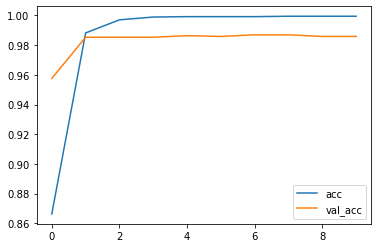

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
rand_text = seq_test[random.randint(0, 1800)]
original = ' '.join([tokenizer.index_word.get(x) for x in rand_text if x != 0])
print(original, '\n')
result = model.predict(rand_text.reshape(1, -1)) >= 0.5
if result:
    print ('Spam')
else:
    print ('Ham')

k k from tomorrow onwards started 

Ham


## 3.2 CNN

In [ ]:
# seq_len = 155
tf.keras.backend.clear_session()

i = Input(shape=(seq_train.shape[1], )) # (m, seq_len)
x = Embedding(V + 1, 300)(i) #(m, seq_len, emb_dim)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x) # (m, 153, 32)
x = MaxPooling1D(3)(x) #(m, 51, 32)
x = Conv1D(64, 3, activation='relu')(x) #(m, 49, 64)
x = MaxPooling1D(pool_size=3)(x) #(m, 16, 64)
x = Conv1D(128, 3, activation='relu')(x) #(m, 14, 128)
x = GlobalMaxPooling1D()(x) # (m, 128)
x = Dense(1, activation='sigmoid')(x) #(m, 1)
model = Model(i, x)

# Compile and fit
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
r = model.fit(seq_train, Ytrain, epochs=10, validation_data=(seq_test, Ytest))

Epoch 1/10
117/117 [==============================] - 9s 68ms/step - loss: 0.4180 - accuracy: 0.8688 - val_loss: 0.0957 - val_accuracy: 0.9706
Epoch 2/10
117/117 [==============================] - 8s 64ms/step - loss: 0.0582 - accuracy: 0.9826 - val_loss: 0.0624 - val_accuracy: 0.9799
Epoch 3/10
117/117 [==============================] - 8s 65ms/step - loss: 0.0134 - accuracy: 0.9962 - val_loss: 0.1679 - val_accuracy: 0.9701
Epoch 4/10
117/117 [==============================] - 8s 66ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0940 - val_accuracy: 0.9815
Epoch 5/10
117/117 [==============================] - 8s 65ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.1109 - val_accuracy: 0.9799
Epoch 6/10
117/117 [==============================] - 8s 65ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.1101 - val_accuracy: 0.9804
Epoch 7/10
117/117 [==============================] - 8s 66ms/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.1160 - val_accuracy: 0.9815

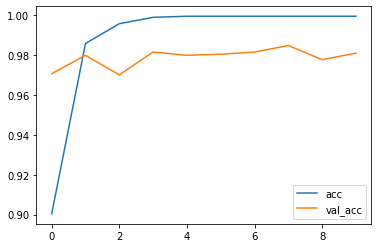

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
rand_text = seq_test[random.randint(0, 1800)]
original = ' '.join([tokenizer.index_word.get(x) for x in rand_text if x != 0])
print(original, '\n')
result = model.predict(rand_text.reshape(1, -1)) >= 0.5
if result:
    print ('Spam')
else:
    print ('Ham')

well done your costa del sol holiday 5000 await collection call 09050090044 now toclaim sae pobox334 stockport sk38xh cost 1 50 pm max10mins 

Spam


In [ ]:
results = model.evaluate(seq_test, Ytest, batch_size=32)
print(results)

58/58 [==============================] - 1s 14ms/step - loss: 0.1330 - accuracy: 0.9810
[0.13300547003746033, 0.9809679388999939]


## 3.3 CNN (Variable NGram)

In [ ]:
class DCNN(Model):
    def __init__(self, vocab_size, nb_classes=2, dropout_rate=0.1, training=False):
        super(DCNN, self).__init__(name="dcnn")
        self.embedding = Embedding(vocab_size, 300)
        self.bigram = Conv1D(filters=128, kernel_size=2, padding="valid", activation="relu")
        self.trigram = Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu")
        self.fourgram = Conv1D(filters=128, kernel_size=4, padding="valid", activation="relu")
        self.pool = GlobalMaxPooling1D() 
        self.dense_1 = Dense(units=256, activation="relu")
        
        self.dropout = Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs) #(m, 155, emb_dim)

        x_1 = self.bigram(x) #(m, 155, 128)
        x_1 = self.pool(x_1) #(m, 128)

        x_2 = self.trigram(x) #(m, 153, 128)
        x_2 = self.pool(x_2) #(m, 128)

        x_3 = self.fourgram(x) #(m, 152, 128)
        x_3 = self.pool(x_3) #(m, 128)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged) # (m, 256)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged) # (m, 1)
        return output

In [ ]:
V = len(tokenizer.word_index) + 1
NB_CLASSES = len(np.unique(Ytrain))
DROPOUT_RATE = 0.2

# model
tf.keras.backend.clear_session()
Dcnn = DCNN(vocab_size=V, nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE)

# compiler
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])
    
# fitting
r = Dcnn.fit(seq_train, Ytrain, batch_size=32, epochs=5, validation_data=(seq_test, Ytest))

Epoch 1/5
117/117 [==============================] - 34s 280ms/step - loss: 0.3622 - accuracy: 0.8747 - val_loss: 0.0687 - val_accuracy: 0.9788
Epoch 2/5
117/117 [==============================] - 32s 278ms/step - loss: 0.0209 - accuracy: 0.9951 - val_loss: 0.0582 - val_accuracy: 0.9810
Epoch 3/5
117/117 [==============================] - 33s 285ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0685 - val_accuracy: 0.9869
Epoch 4/5
117/117 [==============================] - 33s 283ms/step - loss: 8.6527e-04 - accuracy: 0.9999 - val_loss: 0.0685 - val_accuracy: 0.9826
Epoch 5/5
117/117 [==============================] - 33s 285ms/step - loss: 3.2071e-04 - accuracy: 1.0000 - val_loss: 0.0802 - val_accuracy: 0.9848


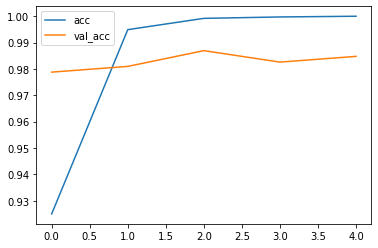

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
results = Dcnn.evaluate(seq_test, Ytest, batch_size=32)
print(results)

58/58 [==============================] - 4s 65ms/step - loss: 0.0802 - accuracy: 0.9848
[0.08022208511829376, 0.9847743511199951]


In [ ]:
rand_text = seq_test[random.randint(0, 1800)]
original = ' '.join([tokenizer.index_word.get(x) for x in rand_text if x != 0])
print(original, '\n')
result = model.predict(rand_text.reshape(1, -1)) >= 0.5
if result:
    print ('Spam')
else:
    print ('Ham')

hi the girl are waiting for you text them text now for great night chatting send stop stop this service 

Ham
